In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
train_class = {}
with open("data/train_set.csv") as f:
    _ = f.readline()
    for line in f:
        k, v = line.strip().split(",")
        train_class[k] = v
len(train_class)

9244

In [3]:
train_volumes_dict = {}
with open("output/train_set_volume.csv") as f:
    _ = f.readline()
    for line in f:
        k, v = line.strip().split(",")
        train_volumes_dict[k] = float(v)
len(train_volumes_dict)

9244

In [4]:
train_inv_shape = {}
for k in tqdm(train_class):
    with open(f"output/train_set/{k}_shape.obj.grid.inv") as f:
        _ = f.readline()
        r = [float(x) for x in f.readlines()]
        assert len(r) == 121
        train_inv_shape[k] = r
print(f"{len(train_inv_shape)=}")

train_inv_pos = {}
for k in tqdm(train_class):
    with open(f"output/train_set/{k}_pos.obj.grid.inv") as f:
        _ = f.readline()
        r = [float(x) for x in f.readlines()]
        assert len(r) == 121
        train_inv_pos[k] = r
print(f"{len(train_inv_pos)=}")

train_inv_neg = {}
for k in tqdm(train_class):
    with open(f"output/train_set/{k}_neg.obj.grid.inv") as f:
        _ = f.readline()
        r = [float(x) for x in f.readlines()]
        assert len(r) == 121
        train_inv_neg[k] = r
print(f"{len(train_inv_neg)=}")


  2%|▏         | 205/9244 [00:00<00:04, 2041.93it/s]

100%|██████████| 9244/9244 [00:04<00:00, 2051.35it/s]


len(train_inv_shape)=9244


100%|██████████| 9244/9244 [00:04<00:00, 2070.11it/s]


len(train_inv_pos)=9244


100%|██████████| 9244/9244 [00:04<00:00, 2104.40it/s]

len(train_inv_neg)=9244


In [5]:
test_volumes_dict = {}
with open("output/test_set_volume.csv") as f:
    _ = f.readline()
    for line in f:
        k, v = line.strip().split(",")
        test_volumes_dict[k] = float(v)
len(test_volumes_dict)

2321

In [6]:
test_inv_shape = {}
for k in tqdm(test_volumes_dict):
    with open(f"output/test_set/{k}_shape.obj.grid.inv") as f:
        _ = f.readline()
        r = [float(x) for x in f.readlines()]
        assert len(r) == 121
        test_inv_shape[k] = r
print(f"{len(test_inv_shape)=}")

test_inv_pos = {}
for k in tqdm(test_volumes_dict):
    with open(f"output/test_set/{k}_pos.obj.grid.inv") as f:
        _ = f.readline()
        r = [float(x) for x in f.readlines()]
        assert len(r) == 121
        test_inv_pos[k] = r
print(f"{len(test_inv_pos)=}")

test_inv_neg = {}
for k in tqdm(test_volumes_dict):
    with open(f"output/test_set/{k}_neg.obj.grid.inv") as f:
        _ = f.readline()
        r = [float(x) for x in f.readlines()]
        assert len(r) == 121
        test_inv_neg[k] = r
print(f"{len(test_inv_neg)=}")


100%|██████████| 2321/2321 [00:01<00:00, 2009.82it/s]


len(test_inv_shape)=2321


100%|██████████| 2321/2321 [00:01<00:00, 2003.99it/s]


len(test_inv_pos)=2321


100%|██████████| 2321/2321 [00:01<00:00, 2009.04it/s]

len(test_inv_neg)=2321


In [7]:
train_keys = list(train_class.keys())
test_keys = list(test_volumes_dict.keys())

# prep the data
training_labels = np.array([train_class[k] for k in train_keys])  # shape: (N,)
training_volumes = np.array([train_volumes_dict[k] for k in train_keys])

test_volumes = np.array([test_volumes_dict[k] for k in test_keys])  # shape: (N_test,)

# 3DZD
training_data_spn = np.array(
    [train_inv_shape[k] + train_inv_pos[k] + train_inv_neg[k] for k in train_keys],
    dtype=np.float32,
)  # shape: (N, 363)
test_data_spn = np.array(
    [test_inv_shape[k] + test_inv_pos[k] + test_inv_neg[k] for k in test_keys],
    dtype=np.float32,
)  # shape: (N_test, 363)


In [8]:
dist_train = cdist(training_data_spn, training_data_spn)
np.fill_diagonal(dist_train, np.inf)
nearest_indices = np.argmin(dist_train, axis=1)
predicted_labels_spn = training_labels[nearest_indices]
accuracy = accuracy_score(training_labels, predicted_labels_spn)
print(f"Training self-evaluation (leave-one-out 1-NN) accuracy: {accuracy:.2%}")
#
np.fill_diagonal(dist_train, np.inf)
dists_spn_filtered = dist_train.copy()
nearest_indices_filtered_spn = np.argmin(dists_spn_filtered, axis=1)
predicted_labels_filtered_spn = training_labels[nearest_indices_filtered_spn]

accuracy_filtered = accuracy_score(training_labels, predicted_labels_filtered_spn)
print(f"Accuracy with volume-filtered 1-NN: {accuracy_filtered:.2%}")


Training self-evaluation (leave-one-out 1-NN) accuracy: 91.33%
Accuracy with volume-filtered 1-NN: 91.33%


In [9]:
dist_matrix = cdist(
    test_data_spn, training_data_spn, metric="euclidean"
)  # shape: (N_test, N_train)

# volume filter
volume_ratios = (
    test_volumes[:, None] / training_volumes[None, :]
)  # shape: (N_test, N_train)
volume_diff_mask = (volume_ratios < 0.8) | (volume_ratios > 1.2)
dist_matrix[volume_diff_mask] = np.inf


In [10]:
# nearlest neighbors index
nearest_indices_test_filtered = np.argmin(dist_matrix, axis=1)

# predicted labels
predicted_test_labels_filtered = training_labels[nearest_indices_test_filtered]

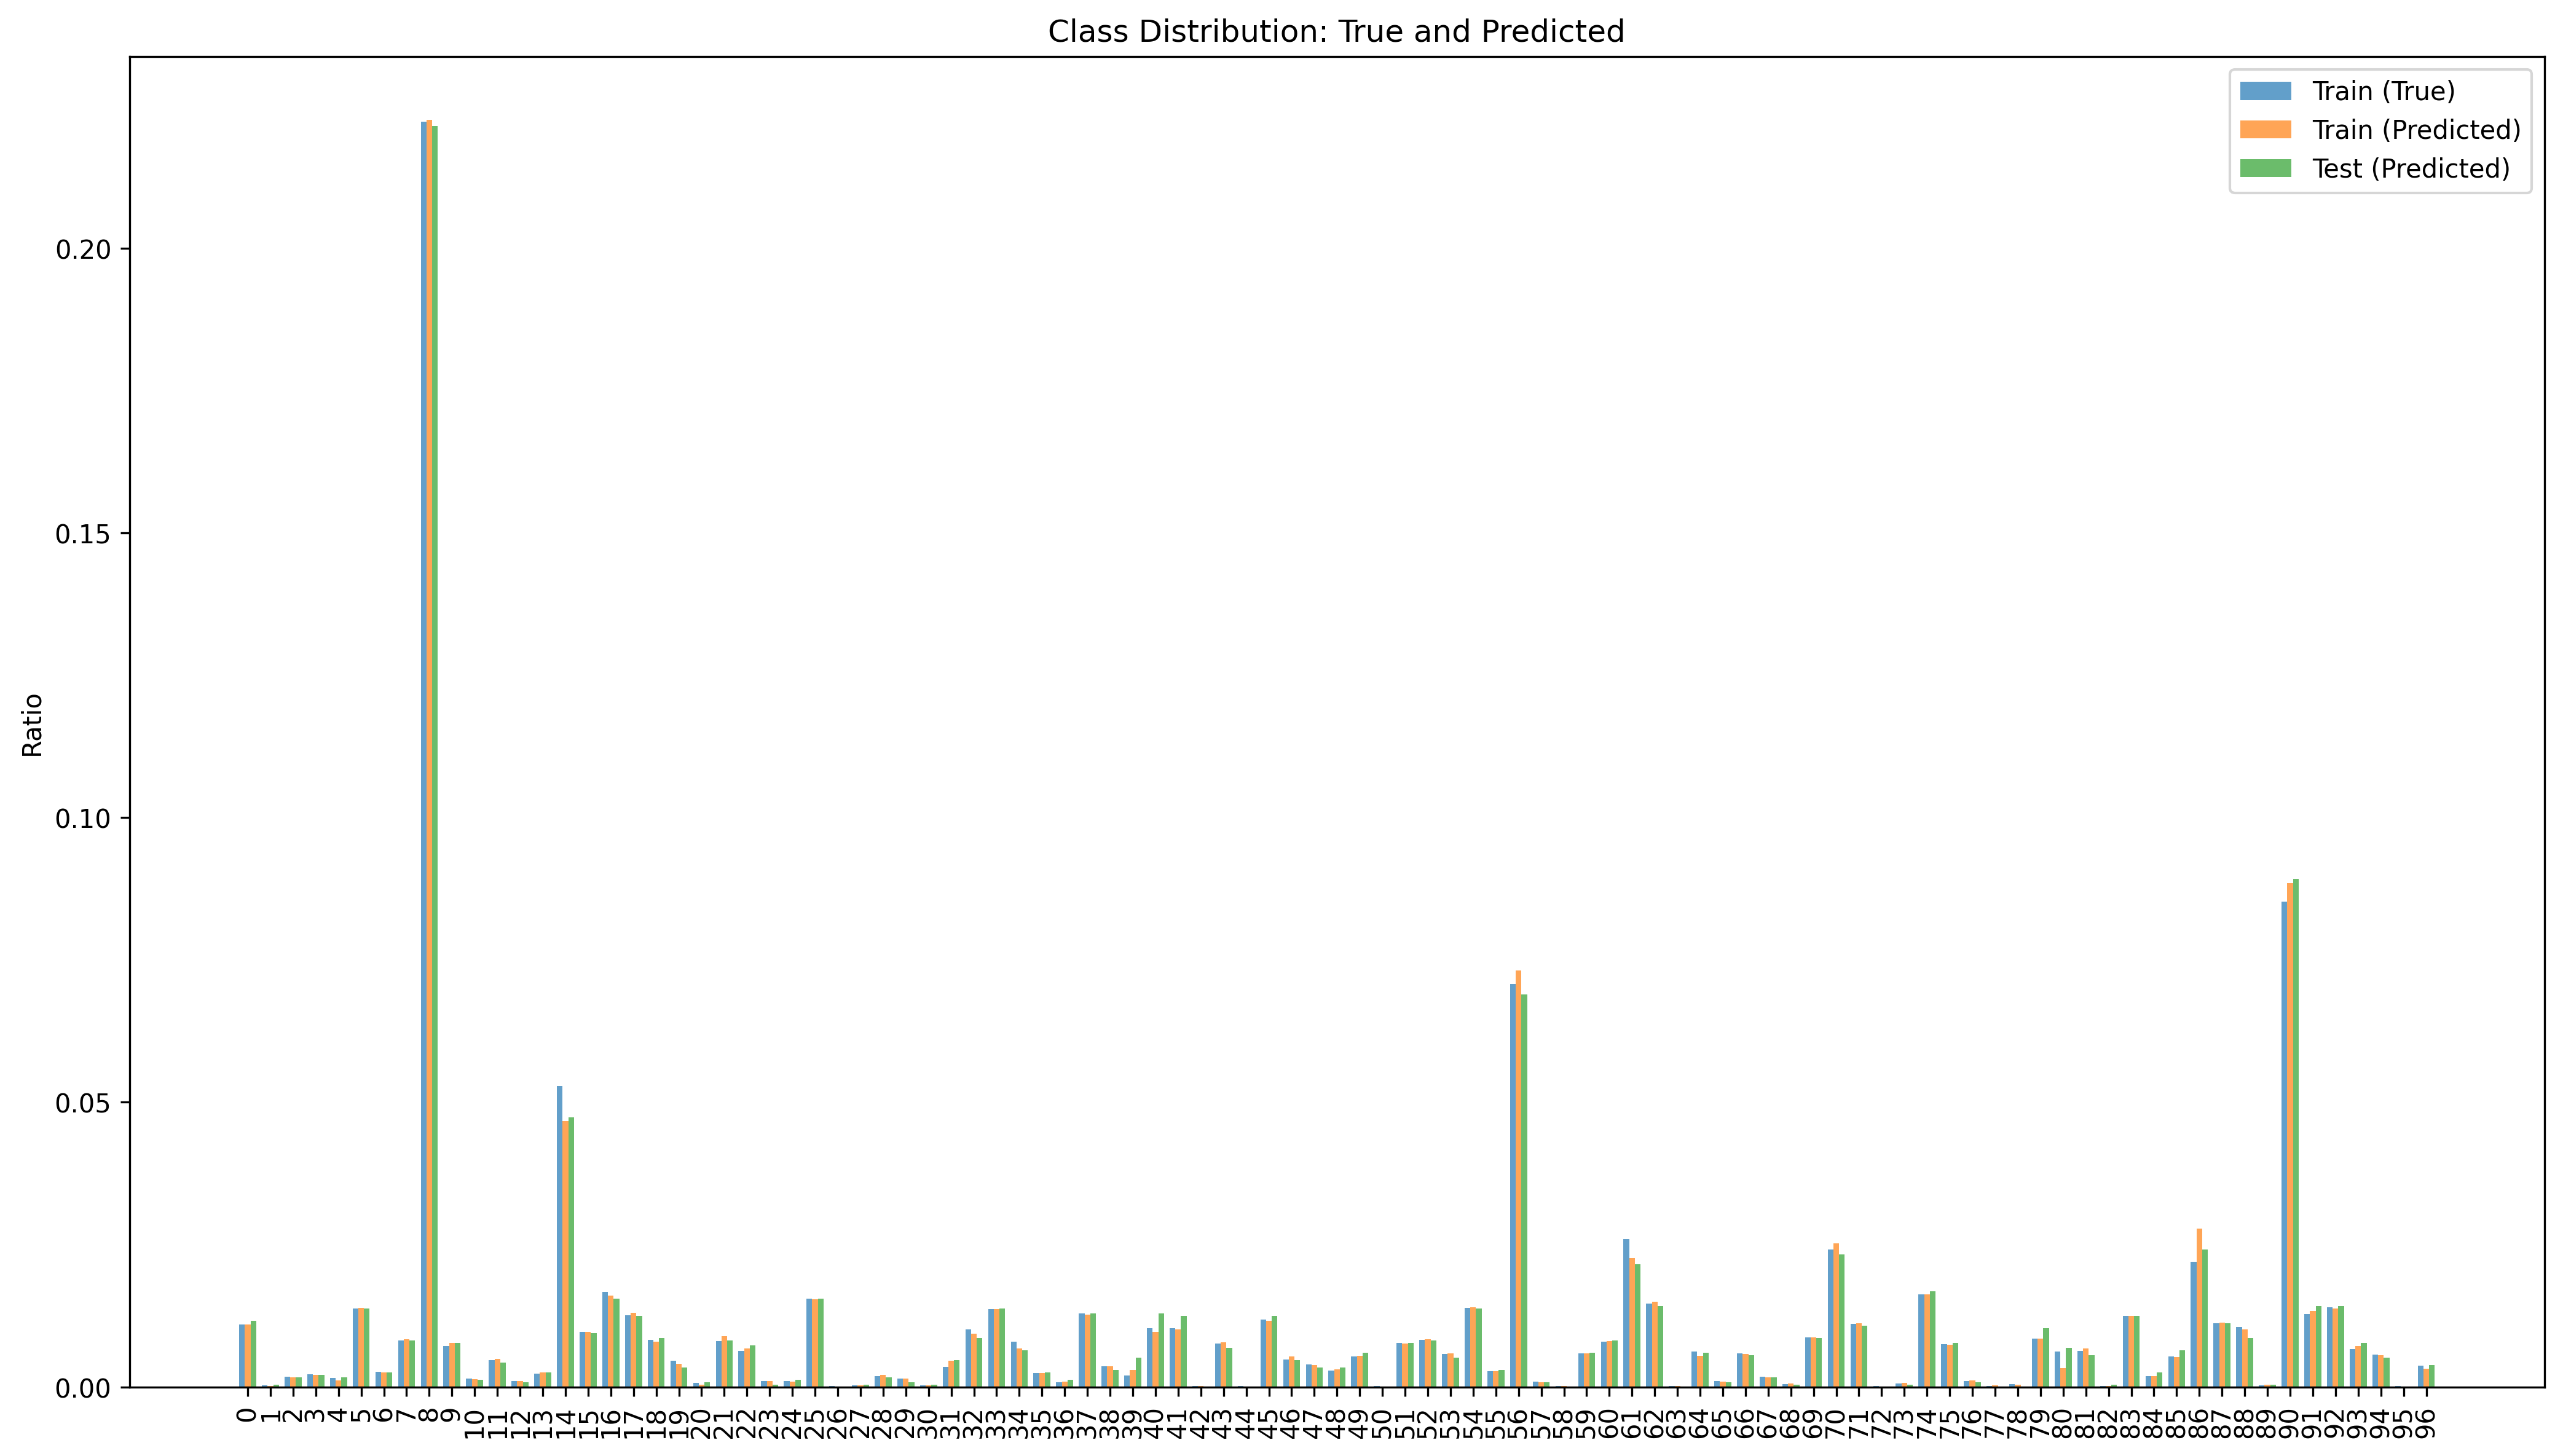

In [11]:
# consistency check
all_labels = sorted(
    set(training_labels) | set(predicted_test_labels_filtered),
    key=lambda x: int(x),
)


def get_ratio(labels, all_labels):
    counts = np.array([np.sum(labels == label) for label in all_labels])
    return counts / counts.sum()


train_ratio = get_ratio(training_labels, all_labels)
train_pred_ratio = get_ratio(predicted_labels_filtered_spn, all_labels)
test_pred_ratio = get_ratio(predicted_test_labels_filtered, all_labels)

x = np.arange(len(all_labels))
width = 0.25

plt.figure(figsize=(14, 8), dpi=300)
plt.bar(x - width, train_ratio, width=width, label="Train (True)", alpha=0.7)
plt.bar(x, train_pred_ratio, width=width, label="Train (Predicted)", alpha=0.7)
plt.bar(x + width, test_pred_ratio, width=width, label="Test (Predicted)", alpha=0.7)

plt.xticks(x, all_labels, rotation=90)
plt.ylabel("Ratio")
plt.title("Class Distribution: True and Predicted")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# save prediction results
rows = []
for i, test_key in enumerate(test_keys):
    nn_idx = nearest_indices_test_filtered[i]
    nn_key = train_keys[nn_idx]
    nn_label = training_labels[nn_idx]
    dist = dist_matrix[i, nn_idx]
    rows.append({"query_key": test_key, "predicted_label": nn_label})

df_test_preds = pd.DataFrame(rows)
df_test_preds.to_csv("test_predictions.csv", index=False)


In [13]:
#
class_to_indices = defaultdict(list)
for idx, label in enumerate(training_labels):
    class_to_indices[label].append(idx)

#
unique_classes = sorted(class_to_indices.keys(), key=lambda x: int(x))

rows = []

# for each example
for i, test_key in enumerate(test_keys):
    dist_row = dist_matrix[i]  # shape: (N_train,)
    row = {"test_key": test_key}

    for cls in unique_classes:
        indices = class_to_indices[cls]
        min_dist = np.min(dist_row[indices])
        row[cls] = min_dist

    rows.append(row)

# convert df and save
df_dissim = pd.DataFrame(rows)
df_dissim.to_csv("test_class_distance_matrix.csv", index=False, float_format="%.4f")
